In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [3]:
# Load data
Places = pd.read_csv('Top-Indian-Places-to-Visit.csv')
ratings = pd.read_csv('IDusers.csv')

In [4]:
df = Places.merge(ratings, how="left", on="ID")
df.head()

,ID,Zone,State,City,Name,Type,Establishment Year,time needed to visit in hrs,Entrance Fee in INR,Airport with 50km Radius,Weekly Off,Significance,DSLR Allowed,Number of google review in lakhs,Best Time to visit,UserID,rating
0,300000,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,0,Yes,NaN,Historical,Yes,2.6,Evening,236,2
1,300000,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,0,Yes,NaN,Historical,Yes,2.6,Evening,239,5
2,300000,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,0,Yes,NaN,Historical,Yes,2.6,Evening,239,4
3,300000,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,0,Yes,NaN,Historical,Yes,2.6,Evening,240,4
4,300000,Northern,Delhi,Delhi,India Gate,War Memorial,1921,0.5,0,Yes,NaN,Historical,Yes,2.6,Evening,242,3


In [5]:
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(33903, 17)
##################### Types #####################
ID                                    int64
Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
UserID                                int64
rating                                int64
dtype: object
##################### Head #####################
       ID      Zone  State   City        Name          Type Establishment Yea

In [6]:
num_counts = pd.DataFrame(df["rating"].value_counts())
num_counts.head(20)

,count
rating,
5,11753
4,7276
3,6093
1,5965
2,2816


In [7]:
ratings = ratings.drop_duplicates(subset=['UserID', 'ID'], keep='first')
ratings.head()

,UserID,ID,rating
0,233,300003,5
1,233,300006,4
2,233,300001,4
3,233,300014,5
6,233,300013,5


In [10]:
n_ratings = len(ratings)
n_tours = len(ratings['ID'].unique())
n_users = len(ratings['UserID'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique placeId's: {n_tours}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per place: {round(n_ratings/n_tours, 2)}")

Number of ratings: 33851
Number of unique placeId's: 325
Number of unique users: 3768
Average ratings per user: 8.98
Average ratings per place: 104.16


In [11]:
# Split data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [12]:
# Function to create user-item matrix
def create_matrix(df):
    N = len(df['UserID'].unique())
    M = len(df['ID'].unique())

    user_mapper = dict(zip(np.unique(df["UserID"]), list(range(N))))
    places_mapper = dict(zip(np.unique(df["ID"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["UserID"])))
    places_inv_mapper = dict(zip(list(range(M)), np.unique(df["ID"])))

    user_index = [user_mapper[i] for i in df['UserID']]
    places_index = [places_mapper[i] for i in df['ID']]

    X = csr_matrix((df["rating"], (user_index, places_index)), shape=(N, M), dtype=float)

    return X, user_mapper, places_mapper, user_inv_mapper, places_inv_mapper

In [13]:
# Create user-item matrices for train and test sets
X_train, user_mapper_train, places_mapper_train, user_inv_mapper_train, places_inv_mapper_train = create_matrix(train_data)
X_test, user_mapper_test, places_mapper_test, user_inv_mapper_test, places_inv_mapper_test = create_matrix(test_data)

# Perform SVD
def svd_recommendation(X, num_components=50):
    # Decompose the user-item matrix
    u, s, vt = svds(X, k=num_components)
    s_diag_matrix = np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

    return X_pred
# Generate predictions
X_pred_cf = svd_recommendation(X_train)


In [14]:
# Create a feature matrix for Content-Based Filtering
places_features = Places[['City', 'Type', 'Significance', 'Best Time to visit']]

# Label encode 'Significance' column
label_encoder = LabelEncoder()
places_features['Significance'] = label_encoder.fit_transform(places_features['Significance'])

# Select categorical and numerical columns
cat_cols = ['City', 'Type', 'Best Time to visit']
num_cols = ['Significance']  # Assuming 'Significance' is numerical after label encoding

# Encode categorical columns
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(places_features[cat_cols])

In [15]:
# Scale numerical columns if needed (optional)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(places_features[num_cols].values.reshape(-1, 1))

# Concatenate encoded categorical features with numerical features
places_features_matrix = csr_matrix(np.hstack([encoded_features.toarray(), scaled_features]))

# Compute the similarity matrix using cosine similarity
place_similarity = cosine_similarity(places_features_matrix)

Train RMSE: 2.8905658715696854
Test RMSE: 2.9440466528349867
Percentage Difference: 1.85%


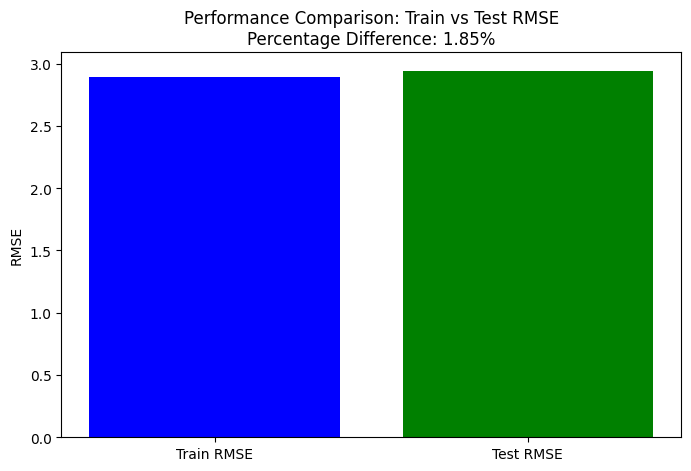

In [16]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Predict ratings for train and test sets
X_pred_train = svd_recommendation(X_train)
X_pred_test = svd_recommendation(X_test)

# Extract the true ratings and predicted ratings for the train set
train_user_indices, train_place_indices = X_train.nonzero()
y_train_true = X_train[train_user_indices, train_place_indices].A1
y_train_pred = X_pred_train[train_user_indices, train_place_indices]

# Extract the true ratings and predicted ratings for the test set
test_user_indices, test_place_indices = X_test.nonzero()
y_test_true = X_test[test_user_indices, test_place_indices].A1
y_test_pred = X_pred_test[test_user_indices, test_place_indices]

# Calculate RMSE for train and test sets
train_rmse = rmse(y_train_true, y_train_pred)
test_rmse = rmse(y_test_true, y_test_pred)

# Calculate percentage difference between train and test RMSE
percentage_difference = ((test_rmse - train_rmse) / train_rmse) * 100

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Percentage Difference: {percentage_difference:.2f}%")

# Plotting the RMSE for comparison
labels = ['Train RMSE', 'Test RMSE']
values = [train_rmse, test_rmse]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green'])
plt.ylabel('RMSE')
plt.title(f'Performance Comparison: Train vs Test RMSE\nPercentage Difference: {percentage_difference:.2f}%')
plt.show()


###Hybrid Recommendation

In [17]:
# Hybrid Recommendation: Combine CF and Content-Based recommendations
def hybrid_recommendation(Places, ratings, user_id, X_pred_cf, place_similarity, alpha=0.5, k=10):
    places_titles = dict(zip(Places['ID'], Places['Name']))
    mean_rating = ratings.groupby('ID')['rating'].mean()

    if user_id not in user_mapper_train:
        print(f"User with ID {user_id} does not exist. Displaying top {k} places with the highest ratings:")
        top_k_places = mean_rating.sort_values(ascending=False).head(k).index.tolist()
        top_k_scores = mean_rating.loc[top_k_places].values
        top_k_titles = [places_titles.get(place_id, "Place not found") for place_id in top_k_places]

        # Plot the top k places with highest ratings
        plt.figure(figsize=(10, 5))
        plt.barh(top_k_titles, top_k_scores, color='skyblue')
        plt.xlabel('Average Rating')
        plt.title(f'Top {k} Places with the Highest Ratings')
        plt.gca().invert_yaxis()
        plt.show()
        return

    user_idx = user_mapper_train[user_id]
    user_ratings_cf = X_pred_cf[user_idx]

    # Content-Based filtering part
    user_ratings_cb = place_similarity.dot(user_ratings_cf)

    # Hybrid recommendation
    user_ratings_hybrid = alpha * user_ratings_cf + (1 - alpha) * user_ratings_cb

    # Get the indices of the top k highest rated places
    top_k_indices = np.argsort(user_ratings_hybrid)[-k:][::-1]

    print(f"Hybrid Recommendations for user {user_id}:")
    recommended_places = []
    recommended_scores = []
    for idx in top_k_indices:
        place_id = places_inv_mapper_train[idx]
        place_title = places_titles.get(place_id, "Place not found")
        recommended_places.append(place_title)
        recommended_scores.append(user_ratings_hybrid[idx])
        print(place_title)

    # Plot the recommendations
    plt.figure(figsize=(10, 5))
    plt.barh(recommended_places, recommended_scores, color='skyblue')
    plt.xlabel('Predicted Point')
    plt.title(f'Hybrid Recommendations for User {user_id}')
    plt.gca().invert_yaxis()
    plt.show()


Hybrid Recommendations for user 315:
Thiksey Monastery
Mallikarjuna Swamy Temple
Baba Harbhajan Singh Temple
Krishna Janmabhoomi
Pahari Mandir
Kedarnath
Sai Baba Temple
Pushkar Lake
Amarnath Cave
Padmanabhaswamy Temple


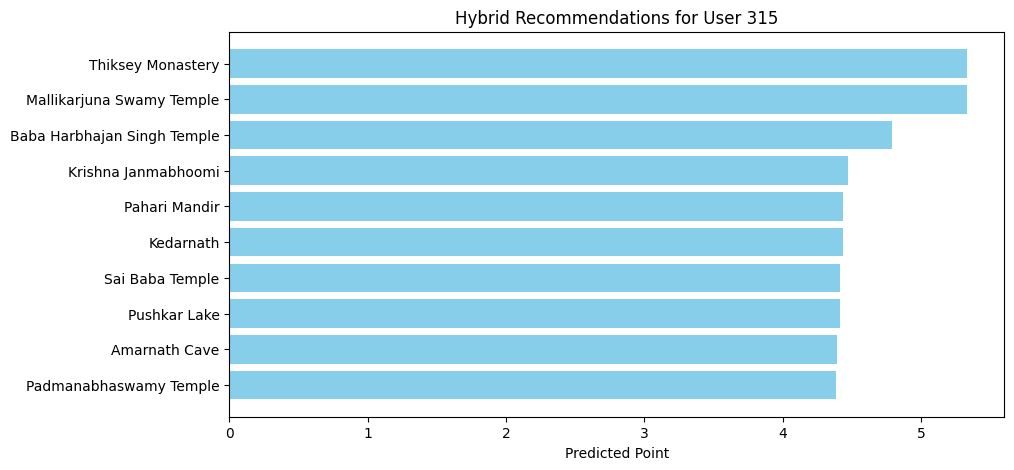

In [20]:
user_id = 315 # Replace with a valid user ID
hybrid_recommendation(Places, ratings,user_id, X_pred_cf, place_similarity, alpha=0.5, k=10)

User with ID 35 does not exist. Displaying top 10 places with the highest ratings:


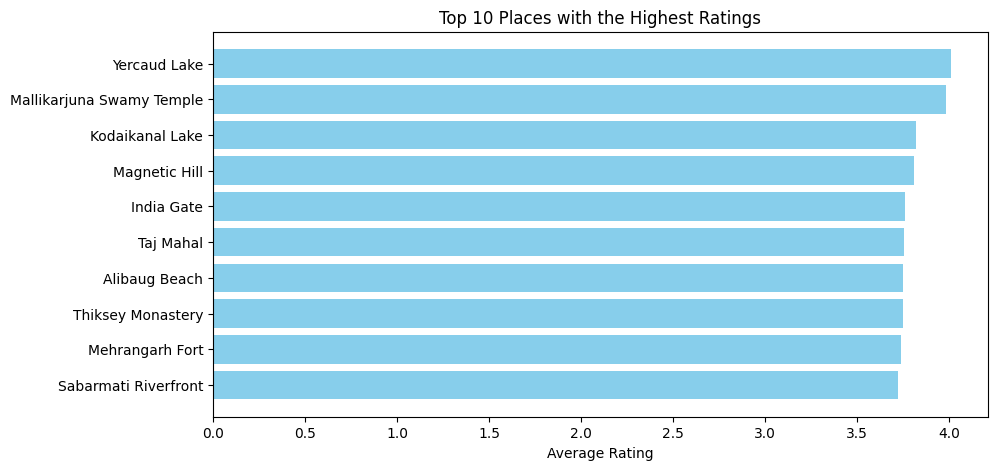

In [21]:
user_id = 35 # That person doesn't have an existing ID yet
hybrid_recommendation(Places, ratings,user_id, X_pred_cf, place_similarity, alpha=0.5, k=10)